# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
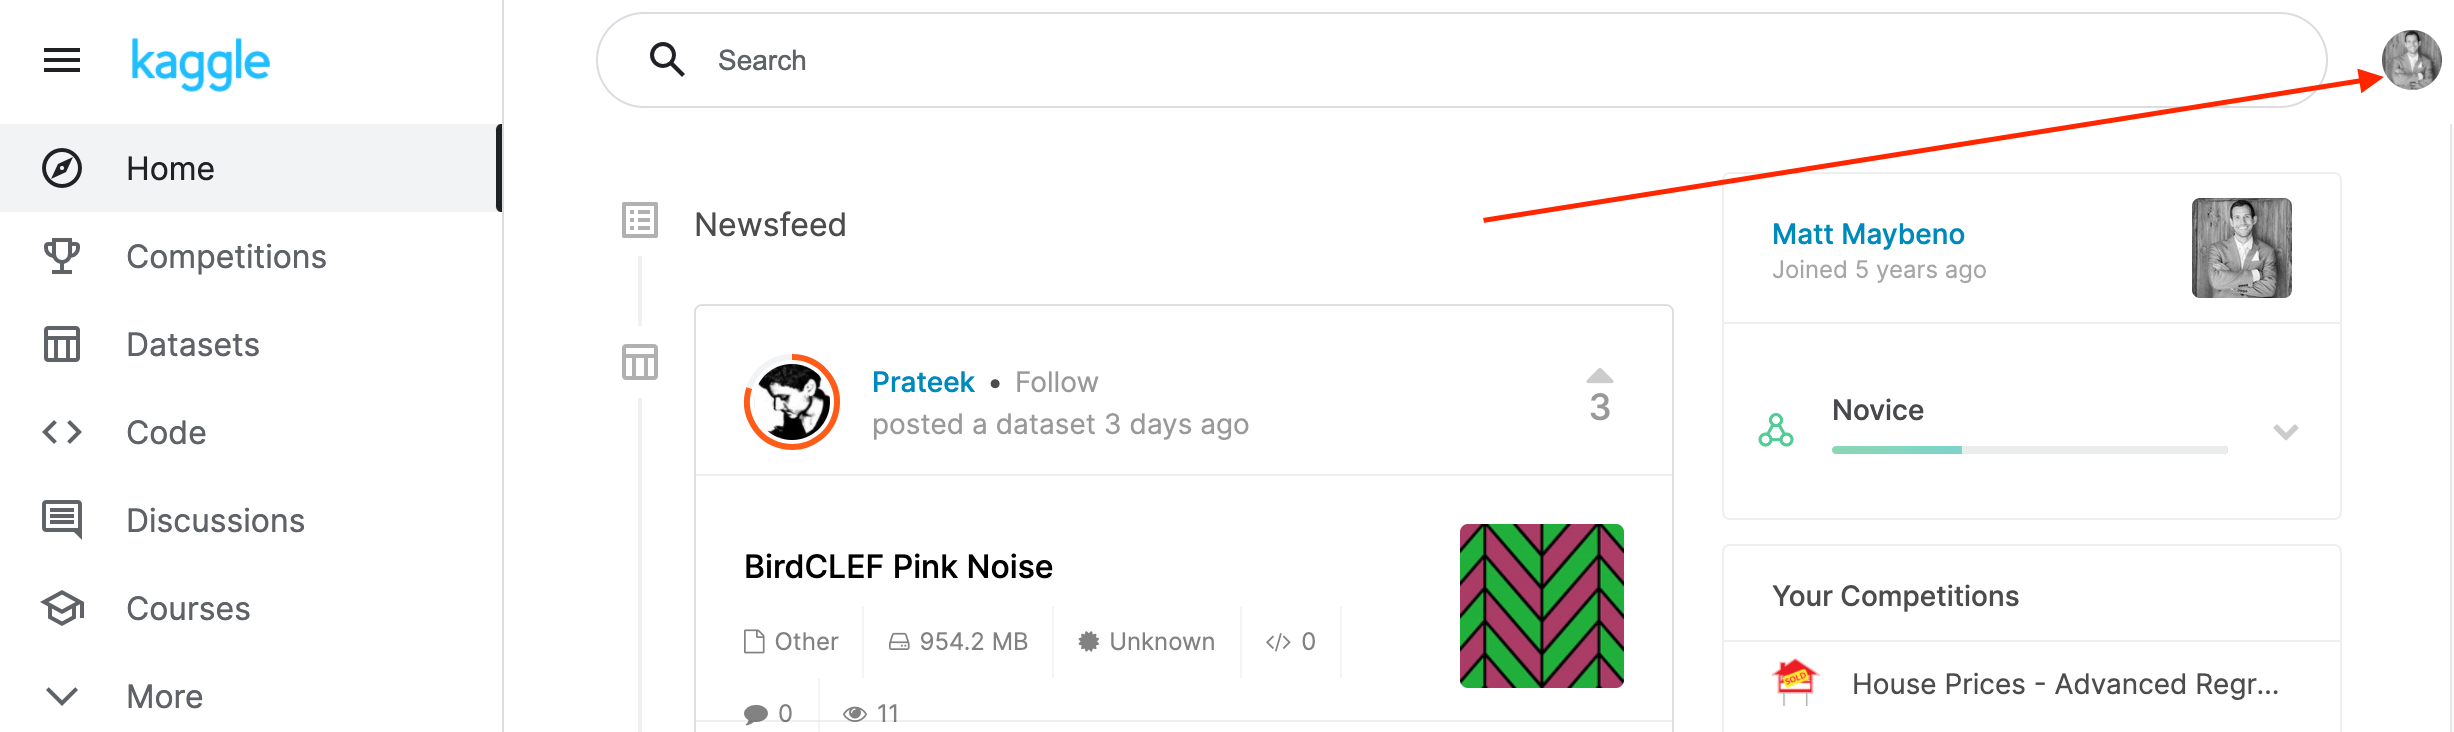
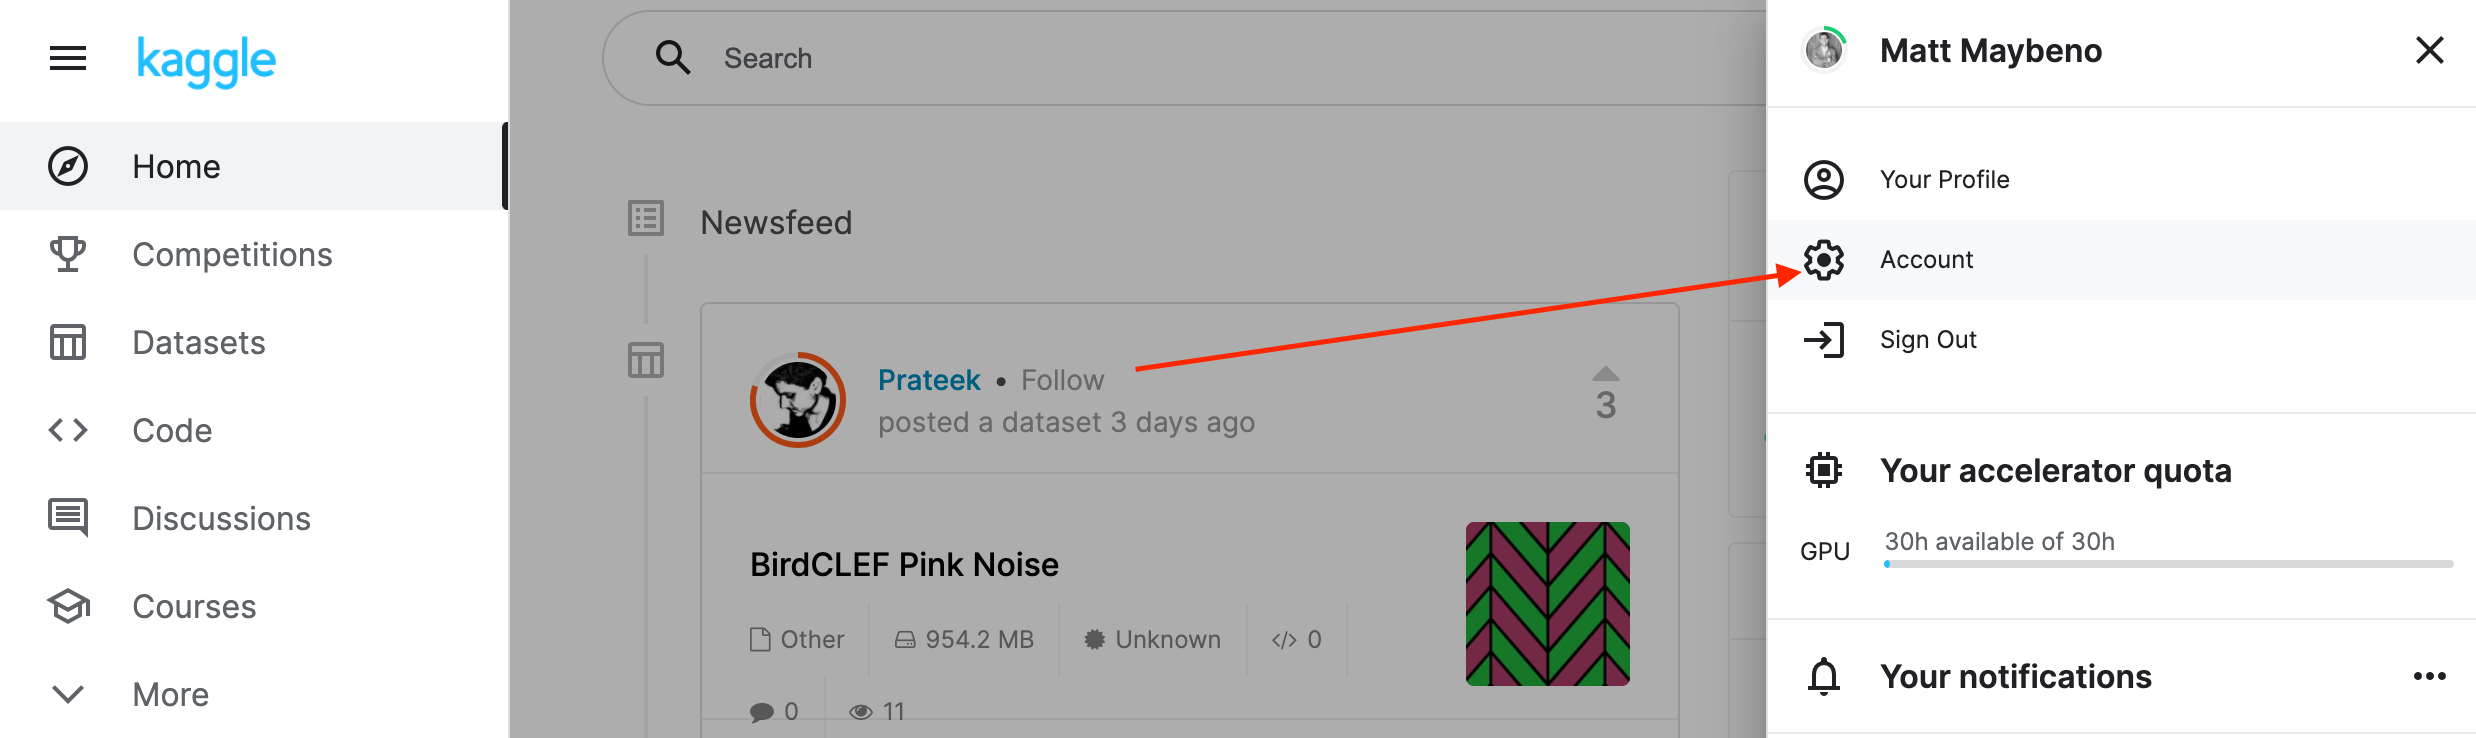
2. Scroll down to API and click Create New API Token.
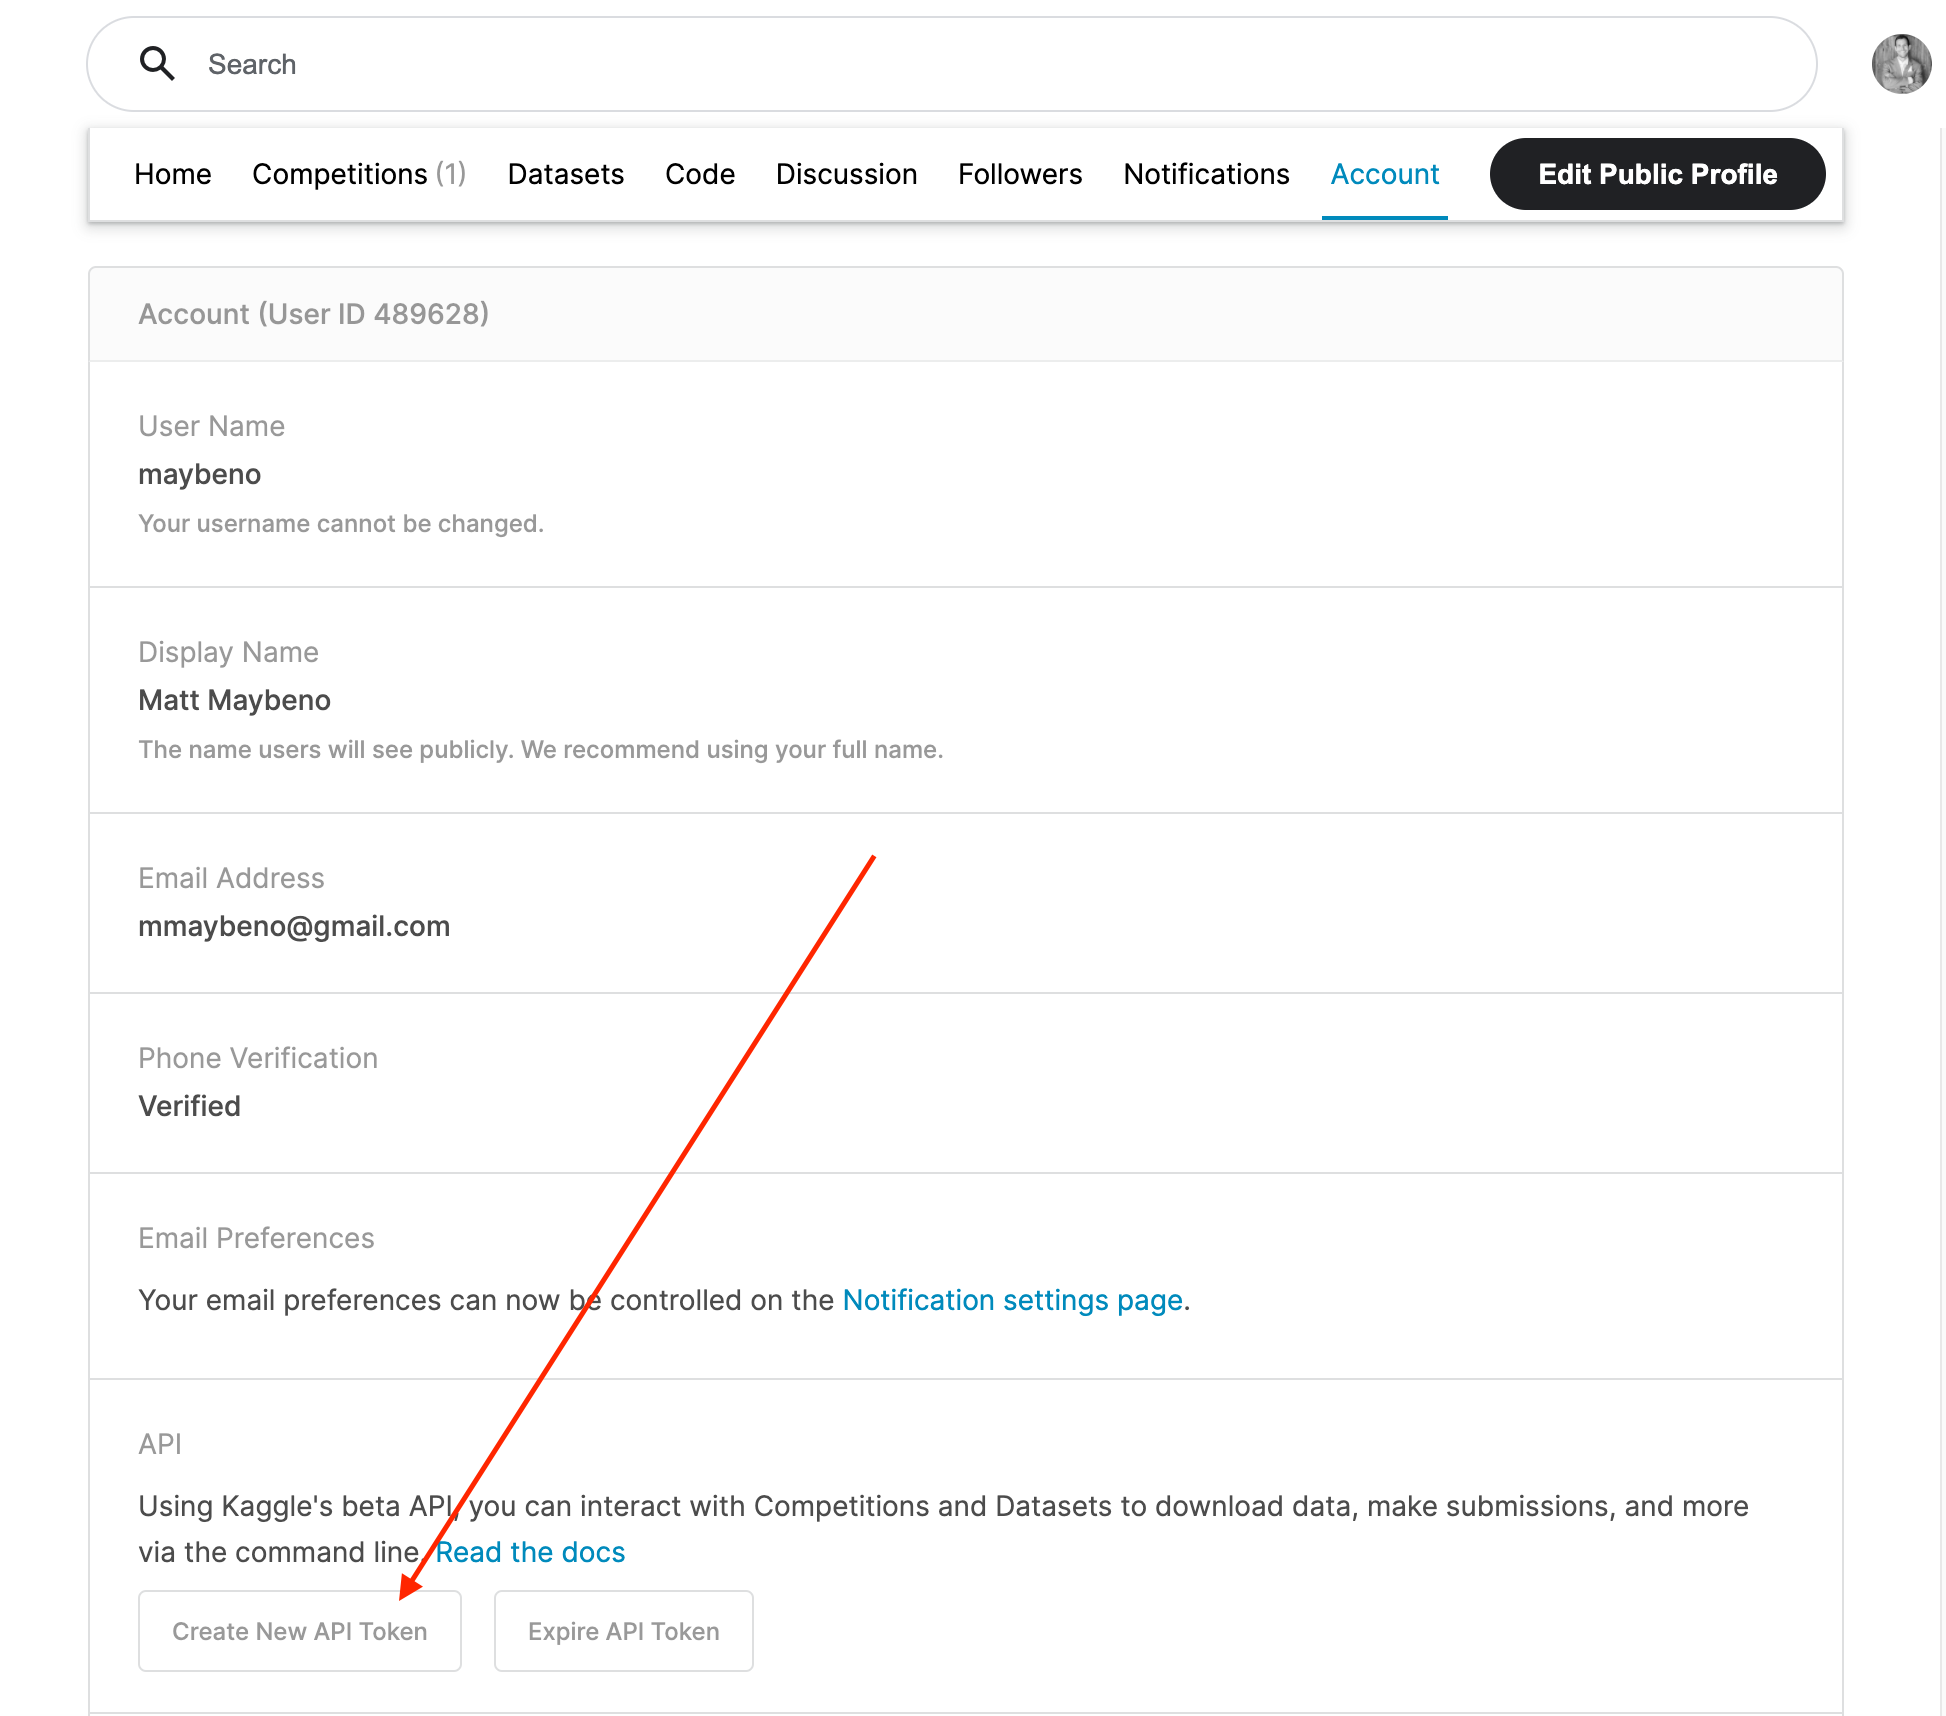
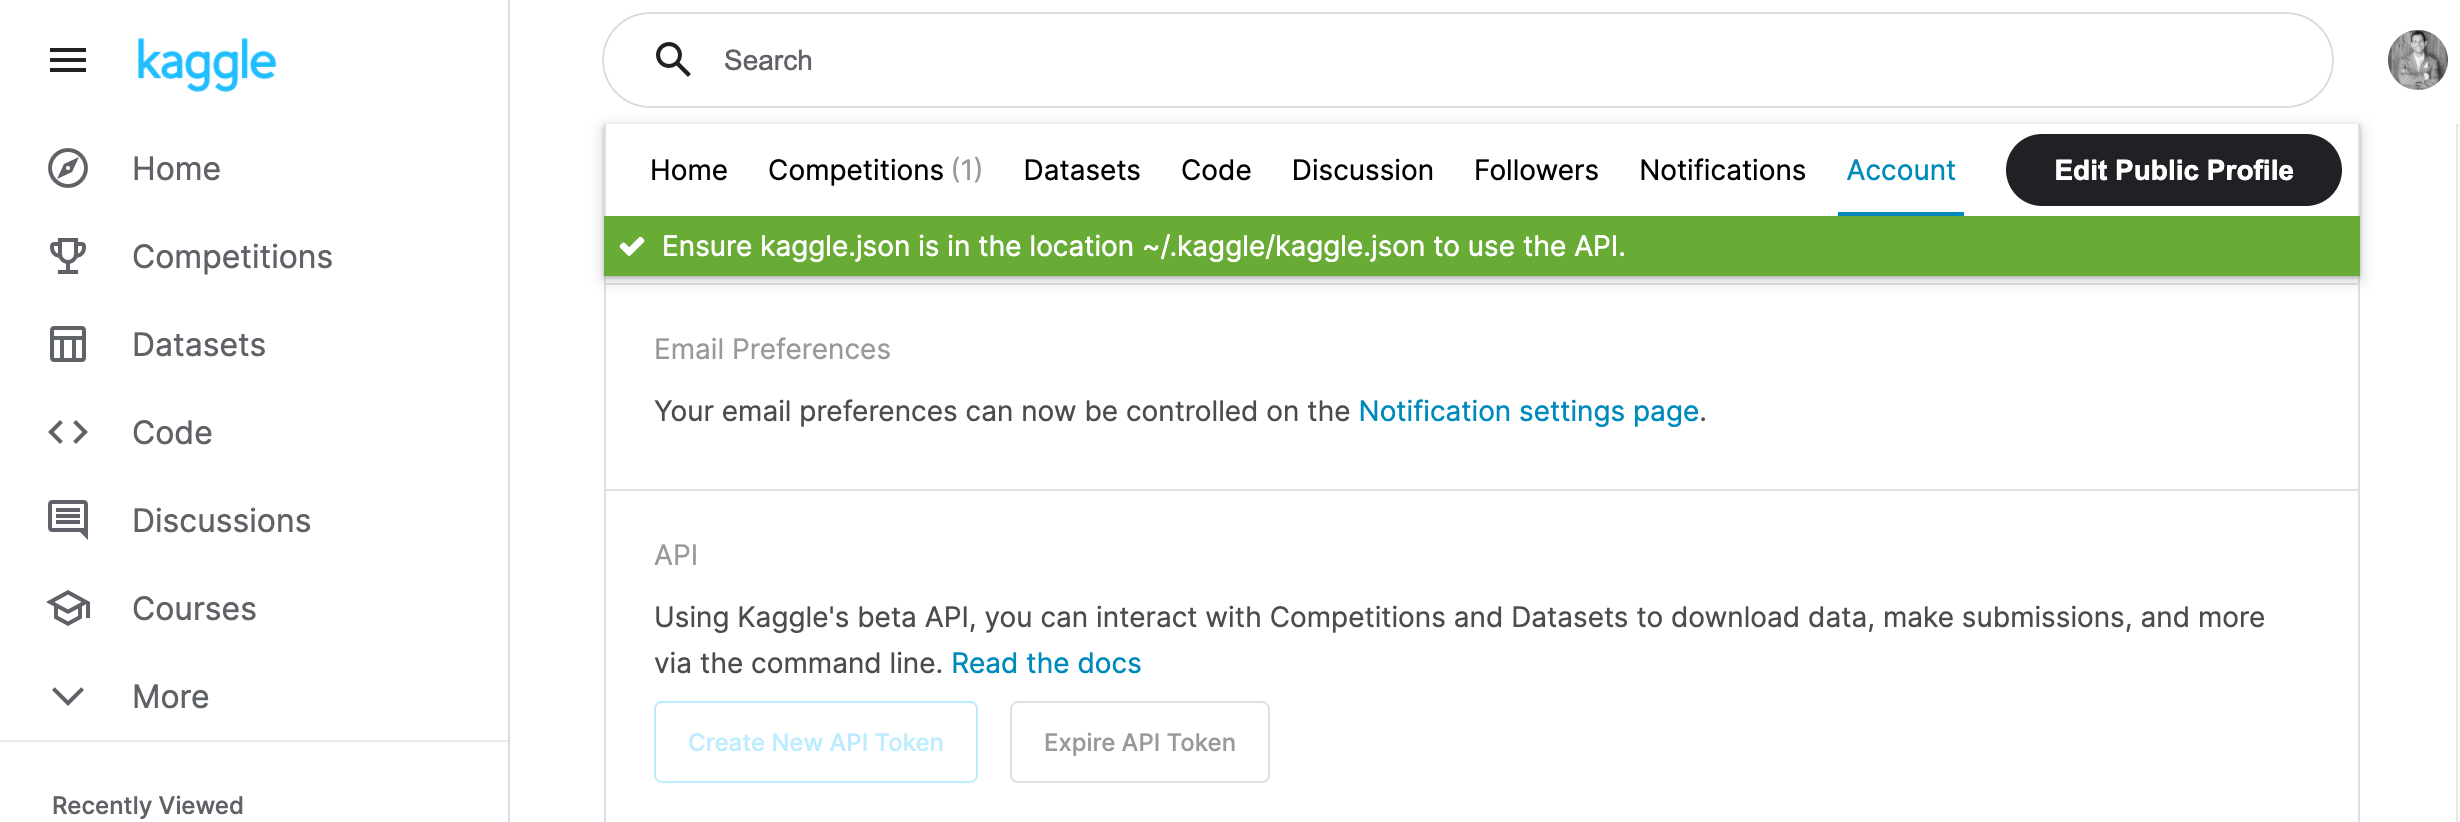
3. Open up `kaggle.json` and use the username and key.
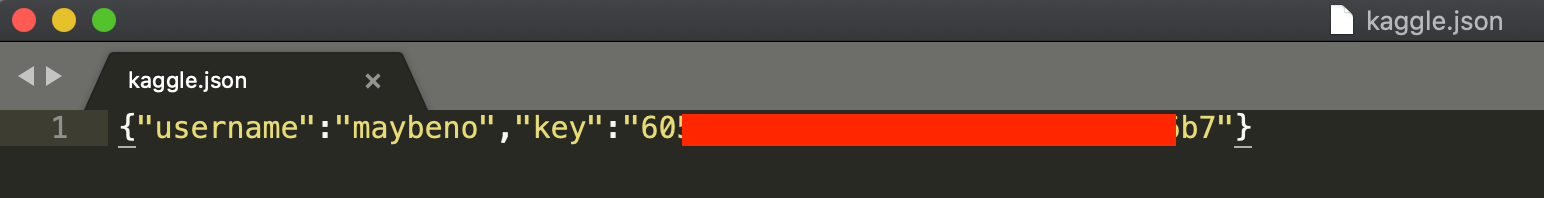

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 4.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.42.0
    Uninstalling wheel-0.42.0:
      Successfully uninstalled wheel-0.42.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.0.3
    Uninstalling setuptools-69.0.3:
      Successfully uninstalled setuptools-69.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires k

In [8]:
import numpy as np
import pandas as pd

from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "amelazib"
kaggle_key = "1ca1b6952103b7bc70bfd48e22fad401"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
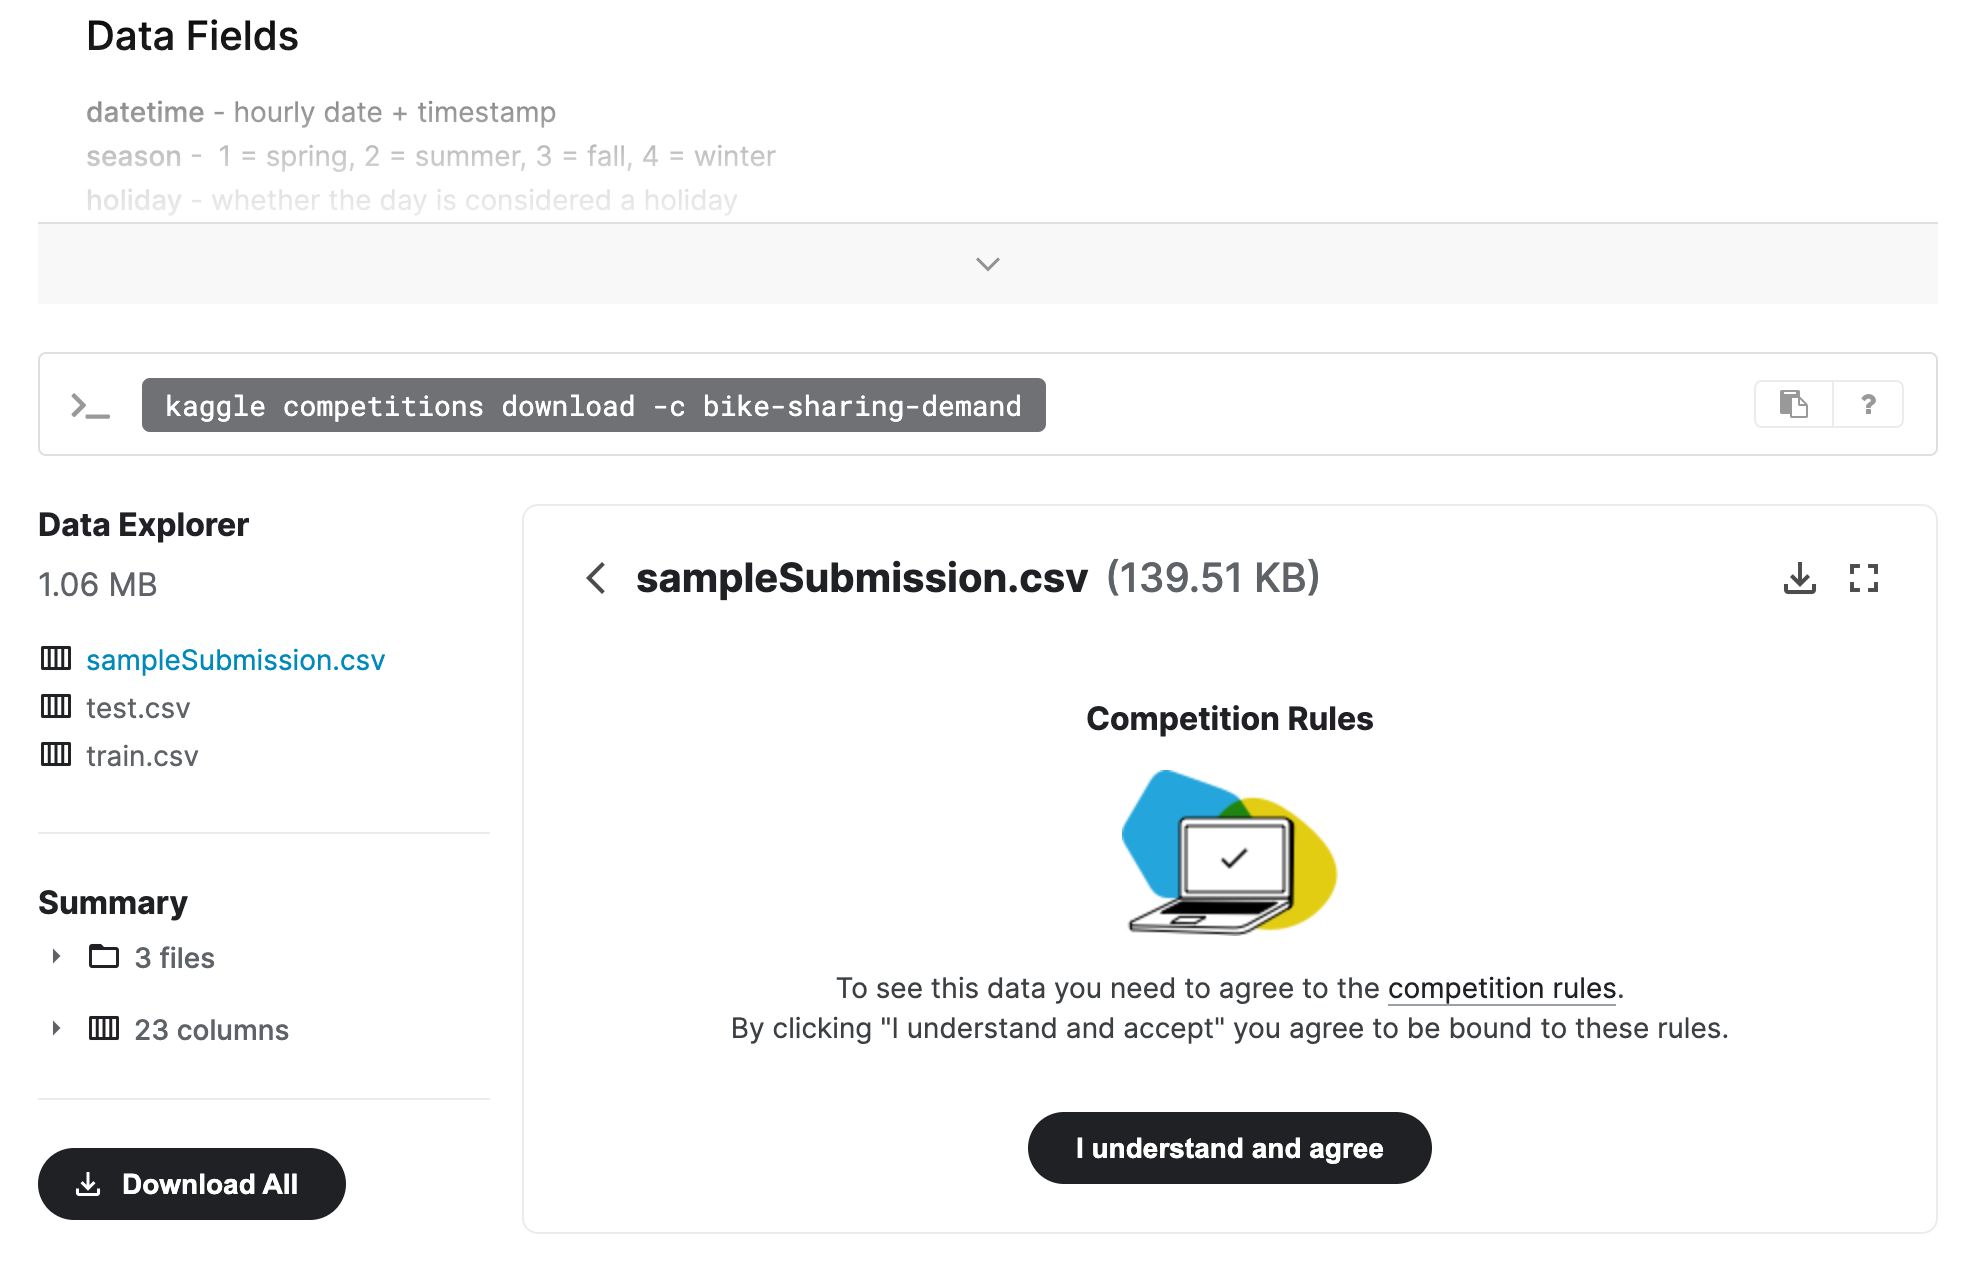

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 94.2MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:

from autogluon.tabular import TabularPredictor

In [9]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later

train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [11]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000     47.000000   
50%        1.000000      1.000000     20.50000     24.240000     62.000000   
75%        1.000000      2.000000     26.24000     31.060000     77.000000   
max        1.000000      4.000000     41.00000     45.455000    100.000000   
std        0.466159      0.633839      7.79159      8.474601     19.245033   

          windspeed        casual    registered         count  
count  10886.000000  10886.000000  10886.000000  10886.000000  
mean      12.799395     36.021955    155.552177    191.574132  
min        0.000000      0.000000      0.000000      1.000000  
25%        7.001500      4.000000     36.000000     42.000000  
50%       12.998000     17.000000    118.000000    145.000000  
75%       16.997900     49.000000    222.000000    284.000000  
max       56.996900    367.000000    886.000000    977.000000  
std        8.164537     49.960477    151.039033    181.144454

In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [11]:
test.describe()

datetime       season      holiday   workingday  \
count                           6493  6493.000000  6493.000000  6493.000000   
mean   2012-01-13 09:27:47.765285632     2.493300     0.029108     0.685815   
min              2011-01-20 00:00:00     1.000000     0.000000     0.000000   
25%              2011-07-22 15:00:00     2.000000     0.000000     0.000000   
50%              2012-01-20 23:00:00     3.000000     0.000000     1.000000   
75%              2012-07-20 17:00:00     3.000000     0.000000     1.000000   
max              2012-12-31 23:00:00     4.000000     1.000000     1.000000   
std                              NaN     1.091258     0.168123     0.464226   

           weather         temp        atemp     humidity    windspeed  
count  6493.000000  6493.000000  6493.000000  6493.000000  6493.000000  
mean      1.436778    20.620607    24.012865    64.125212    12.631157  
min       1.000000     0.820000     0.000000    16.000000     0.000000  
25%       1.000000    13.940000    16.665000    49.000000     7.001500  
50%       1.000000    21.320000    25.000000    65.000000    11.001400  
75%       2.000000    27.060000    31.060000    81.000000    16.997900  
max       4.000000    40.180000    50.000000   100.000000    55.998600  
std       0.648390     8.059583     8.782741    19.293391     8.250151

In [12]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

In [13]:
# Exclude "casual" and "registered" columns
train = train.drop(["casual", "registered"], axis=1)


In [14]:
pip install -U "ray[train]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 MB 20.5 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: ray
    Found existing installation: ray 2.10.0
    Uninstalling ray-2.10.0:
      Successfully uninstalled ray-2.10.0
Note: you may need to restart the kernel to use updated packages.


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [16]:
predictor = TabularPredictor(label='count',eval_metric='root_mean_squared_error').fit( train_data=train,
    time_limit=600,
    presets="best_quality",)

No path specified. Models will be saved in: "AutogluonModels/ag-20240421_165532"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240421_165532/ds_sub_fit/sub_fit_ho.
/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDepen

[1000]	valid_set's rmse: 129.692
[2000]	valid_set's rmse: 128.562
[3000]	valid_set's rmse: 128.461
[1000]	valid_set's rmse: 130.657
[2000]	valid_set's rmse: 129.849
[1000]	valid_set's rmse: 132.725
[1000]	valid_set's rmse: 128.154
[2000]	valid_set's rmse: 126.702
[3000]	valid_set's rmse: 126.147
[4000]	valid_set's rmse: 125.904
[5000]	valid_set's rmse: 125.681
[6000]	valid_set's rmse: 125.468
[7000]	valid_set's rmse: 125.4
[8000]	valid_set's rmse: 125.498
[9000]	valid_set's rmse: 125.618
[1000]	valid_set's rmse: 135.845
[2000]	valid_set's rmse: 134.443
[3000]	valid_set's rmse: 133.639
[4000]	valid_set's rmse: 133.013
[5000]	valid_set's rmse: 132.706
[6000]	valid_set's rmse: 132.628
[7000]	valid_set's rmse: 132.416
[8000]	valid_set's rmse: 132.379
[9000]	valid_set's rmse: 132.422
[1000]	valid_set's rmse: 137.712
[2000]	valid_set's rmse: 136.347
[3000]	valid_set's rmse: 135.865
[4000]	valid_set's rmse: 135.344
[5000]	valid_set's rmse: 135.358
[6000]	valid_set's rmse: 135.139
[7000]	valid

	-131.9758	 = Validation score   (-root_mean_squared_error)
	51.69s	 = Training   runtime
	1.37s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 43.41s of the 93.38s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 129.274
[1000]	valid_set's rmse: 129.285
[1000]	valid_set's rmse: 135.098
[1000]	valid_set's rmse: 124.896
[1000]	valid_set's rmse: 134.058
[1000]	valid_set's rmse: 134.479
[1000]	valid_set's rmse: 136.511


	-131.8496	 = Validation score   (-root_mean_squared_error)
	11.9s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 30.67s of the 80.64s of remaining time.
	-119.5485	 = Validation score   (-root_mean_squared_error)
	5.44s	 = Training   runtime
	0.59s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 24.22s of the 74.19s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 740.
	Ran out of time, early stopping on iteration 946.
	Ran out of time, early stopping on iteration 970.
	Ran out of time, early stopping on iteration 984.
	Ran out of time, early stopping on iteration 1031.
	Ran out of time, early stopping on iteration 1082.
	Ran out of time, early stopping on iteration 1151.
	Ran out of time, early stopping on iteration 1332.
	-133.3576	 = Validation score   (-root_mean_squared_erro

[1000]	valid_set's rmse: 69.3028
[1000]	valid_set's rmse: 70.7429
[1000]	valid_set's rmse: 78.8634
[1000]	valid_set's rmse: 73.0781
[1000]	valid_set's rmse: 75.6864
[1000]	valid_set's rmse: 76.3124
[1000]	valid_set's rmse: 71.8054
[1000]	valid_set's rmse: 74.7241


	-73.6387	 = Validation score   (-root_mean_squared_error)
	20.32s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 25.68s of the 25.62s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-68.007	 = Validation score   (-root_mean_squared_error)
	7.28s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 18.24s of the 18.18s of remaining time.
	-67.0085	 = Validation score   (-root_mean_squared_error)
	14.44s	 = Training   runtime
	0.61s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2.79s of the 2.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 87.
	Ran out of time, early stopping on iteration 90.
	Ran out of time, early stopping on iteration 92.
	Ran out of time,

[1000]	valid_set's rmse: 131.684
[2000]	valid_set's rmse: 130.67
[3000]	valid_set's rmse: 130.626
[1000]	valid_set's rmse: 135.592
[1000]	valid_set's rmse: 133.481
[2000]	valid_set's rmse: 132.323
[3000]	valid_set's rmse: 131.618
[4000]	valid_set's rmse: 131.443
[5000]	valid_set's rmse: 131.265
[6000]	valid_set's rmse: 131.277
[7000]	valid_set's rmse: 131.443
[1000]	valid_set's rmse: 128.503
[2000]	valid_set's rmse: 127.654
[3000]	valid_set's rmse: 127.227
[4000]	valid_set's rmse: 127.105
[1000]	valid_set's rmse: 134.135
[2000]	valid_set's rmse: 132.272
[3000]	valid_set's rmse: 131.286
[4000]	valid_set's rmse: 130.752
[5000]	valid_set's rmse: 130.363
[6000]	valid_set's rmse: 130.509
[1000]	valid_set's rmse: 136.168
[2000]	valid_set's rmse: 135.138
[3000]	valid_set's rmse: 135.029
[1000]	valid_set's rmse: 134.061
[2000]	valid_set's rmse: 133.034
[3000]	valid_set's rmse: 132.182
[4000]	valid_set's rmse: 131.997
[5000]	valid_set's rmse: 131.643
[6000]	valid_set's rmse: 131.504
[7000]	vali

	-131.4609	 = Validation score   (-root_mean_squared_error)
	47.83s	 = Training   runtime
	1.48s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 244.24s of the 392.59s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 130.818
[1000]	valid_set's rmse: 133.204
[1000]	valid_set's rmse: 130.928
[1000]	valid_set's rmse: 126.846
[1000]	valid_set's rmse: 131.426
[1000]	valid_set's rmse: 133.655
[1000]	valid_set's rmse: 132.155
[1000]	valid_set's rmse: 130.62


	-131.0542	 = Validation score   (-root_mean_squared_error)
	13.29s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 229.93s of the 378.28s of remaining time.
	-116.5484	 = Validation score   (-root_mean_squared_error)
	6.15s	 = Training   runtime
	0.59s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 222.63s of the 370.99s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 4005.
	Ran out of time, early stopping on iteration 4054.
	Ran out of time, early stopping on iteration 4169.
	Ran out of time, early stopping on iteration 4276.
	Ran out of time, early stopping on iteration 4388.
	Ran out of time, early stopping on iteration 5365.
	-130.5999	 = Validation score   (-root_mean_squared_error)
	186.22s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG

[1000]	valid_set's rmse: 60.2345
[2000]	valid_set's rmse: 59.2616
[3000]	valid_set's rmse: 59.1292
[1000]	valid_set's rmse: 60.6761
[2000]	valid_set's rmse: 59.7483
[1000]	valid_set's rmse: 62.9612
[2000]	valid_set's rmse: 62.3064
[1000]	valid_set's rmse: 63.4197
[2000]	valid_set's rmse: 61.5995
[3000]	valid_set's rmse: 61.5005
[1000]	valid_set's rmse: 57.6001
[2000]	valid_set's rmse: 57.1637
[1000]	valid_set's rmse: 62.3962
[2000]	valid_set's rmse: 61.3339
[1000]	valid_set's rmse: 63.5228
[2000]	valid_set's rmse: 62.6311
[1000]	valid_set's rmse: 58.6017
[2000]	valid_set's rmse: 57.4886


	-60.1388	 = Validation score   (-root_mean_squared_error)
	37.53s	 = Training   runtime
	1.35s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 107.7s of the 107.64s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-54.7408	 = Validation score   (-root_mean_squared_error)
	10.09s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 97.31s of the 97.25s of remaining time.
	-53.22	 = Validation score   (-root_mean_squared_error)
	19.67s	 = Training   runtime
	0.62s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 76.46s of the 76.4s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1655.
	Ran out of time, early stopping on iteration 1694.
	Ran out of time, early stopping on iteration 1724.
	Ran out 

### Review AutoGluon's training run with ranking of models that did the best.

In [17]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.528411  root_mean_squared_error       4.805283  312.142559                0.000623           0.044947            3       True         16
1   RandomForestMSE_BAG_L2  -53.220006  root_mean_squared_error       4.059544  296.960371                0.624120          19.669342            2       True         13
2     ExtraTreesMSE_BAG_L2  -53.513662  root_mean_squared_error       4.068869  282.335231                0.633445           5.044202            2       True         15
3          LightGBM_BAG_L2  -54.740828  root_mean_squared_error       3.547095  287.384068                0.111671          10.093040            2       True         12
4          CatBoost_BAG_L2  -55.522359  root_mean_squared_error       3.476792  345.277964   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.63296540177245,
  'KNeighborsDist_BAG_L1': -84.16949269107224,
  'LightGBMXT_BAG_L1': -131.

### Create predictions from test dataset

In [18]:
predictions = predictor.predict(test)
predictions.head()

INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


0    23.985424
1    43.049286
2    47.307320
3    49.874916
4    52.323528
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [19]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.302017
std        89.842888
min         2.960155
25%        20.464434
50%        63.010189
75%       170.474213
max       362.368591
Name: count, dtype: float64

In [20]:
# How many negative values do we have?
negative_values = predictions.value_counts().get(-1, 0)  # Count occurrences of -1 (negative values)
print(f"Number of negative values: {negative_values}")


Number of negative values: 0


In [21]:
# Set them to zero
# Set them to zero 
predictions[predictions<0] = 0    # (In case, if negative values exist in the predictions, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


### Set predictions to submission dataframe, save, and submit

In [23]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [24]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 503kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [25]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2024-04-21 17:16:02  first raw submission  complete  1.81005      1.81005       


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

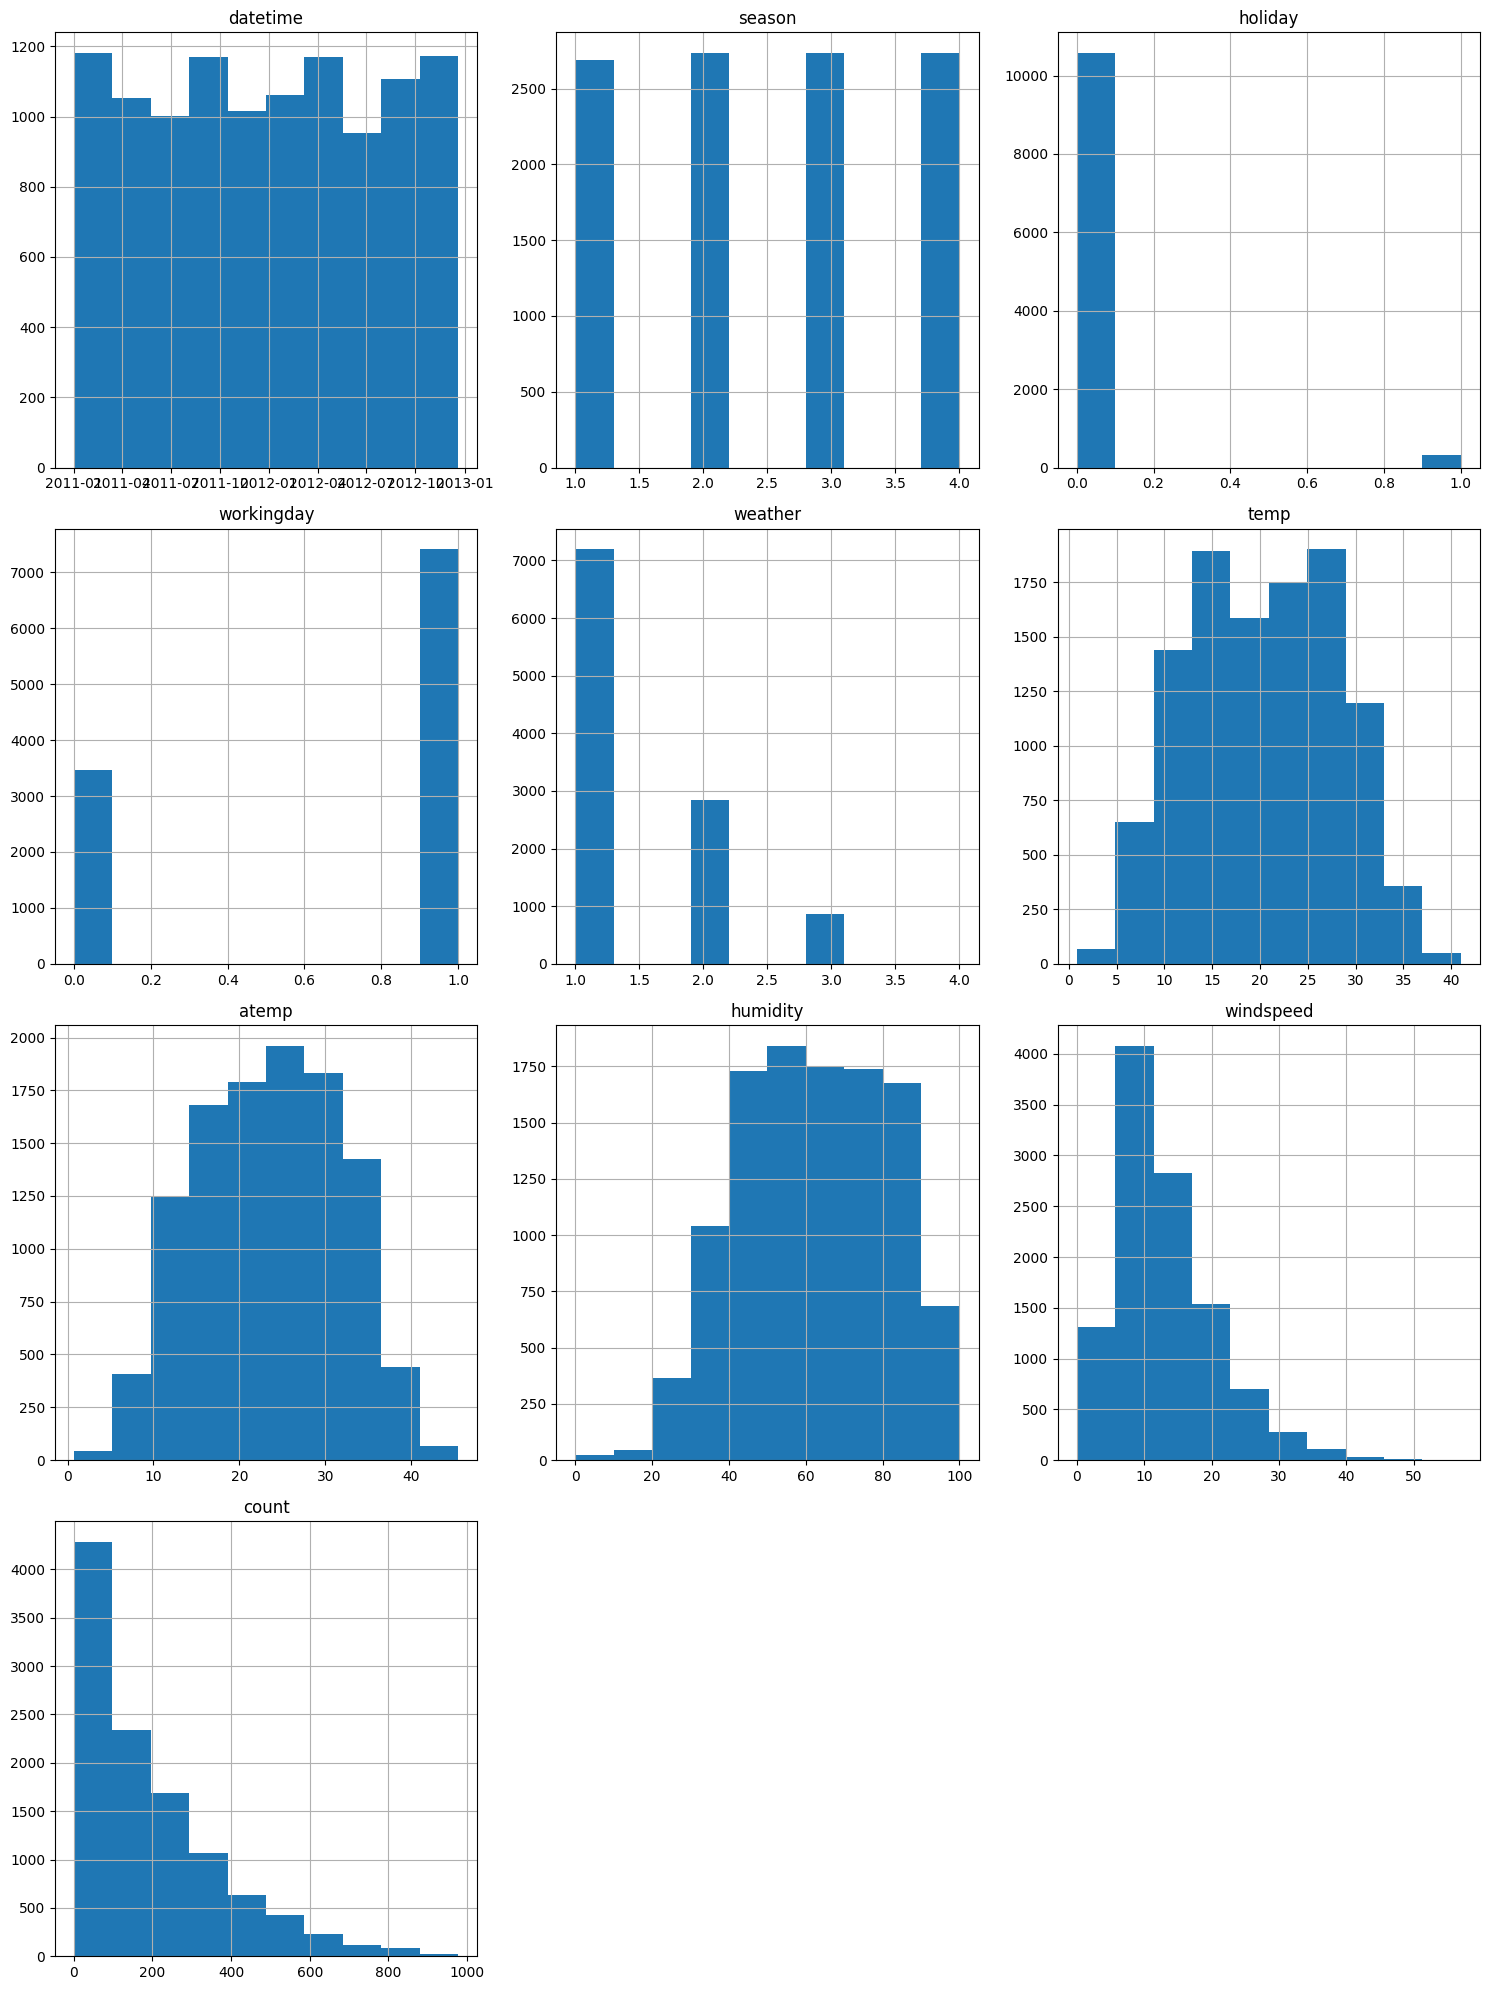

In [28]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
import matplotlib.pyplot as plt
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

In [32]:
# create a new feature
# checking datetime feaute in tranin and test data
train['datetime'].head()
test['datetime'] .head()

0   2011-01-20 00:00:00
1   2011-01-20 01:00:00
2   2011-01-20 02:00:00
3   2011-01-20 03:00:00
4   2011-01-20 04:00:00
Name: datetime, dtype: datetime64[ns]

In [11]:
# Splitting the 'datetime' feature in train data
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.dayofweek  # Note: day -> dayofweek (0->Monday, 6->Sunday)
train["hour"] = train["datetime"].dt.hour
train.drop(["datetime"], axis=1, inplace=True)     # Drop 'datetime' feature
train.head()

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   count  year  month  day  hour  
0     16  2011      1    5     0  
1     40  2011      1    5     1  
2     32  2011      1    5     2  
3     13  2011      1    5     3  
4      1  2011      1    5     4

In [12]:
# Splitting the 'datetime' feature in test data
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.dayofweek  # Note: day -> dayofweek (0->Monday, 6->Sunday)
test["hour"] = test["datetime"].dt.hour
test.drop(["datetime"], axis=1, inplace=True)   # Drop 'datetime' feature
test.head()

season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           1        1  10.66  11.365        56    26.0027   
1       1        0           1        1  10.66  13.635        56     0.0000   
2       1        0           1        1  10.66  13.635        56     0.0000   
3       1        0           1        1  10.66  12.880        56    11.0014   
4       1        0           1        1  10.66  12.880        56    11.0014   

   year  month  day  hour  
0  2011      1    3     0  
1  2011      1    3     1  
2  2011      1    3     2  
3  2011      1    3     3  
4  2011      1    3     4

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [13]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [14]:
# View are new feature
train.head()

season  holiday  workingday weather  temp   atemp  humidity  windspeed  \
0      1        0           0       1  9.84  14.395        81        0.0   
1      1        0           0       1  9.02  13.635        80        0.0   
2      1        0           0       1  9.02  13.635        80        0.0   
3      1        0           0       1  9.84  14.395        75        0.0   
4      1        0           0       1  9.84  14.395        75        0.0   

   count  year  month  day  hour  
0     16  2011      1    5     0  
1     40  2011      1    5     1  
2     32  2011      1    5     2  
3     13  2011      1    5     3  
4      1  2011      1    5     4

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   year        10886 non-null  int32   
 10  month       10886 non-null  int32   
 11  day         10886 non-null  int32   
 12  hour        10886 non-null  int32   
dtypes: category(2), float64(3), int32(4), int64(4)
memory usage: 787.2 KB


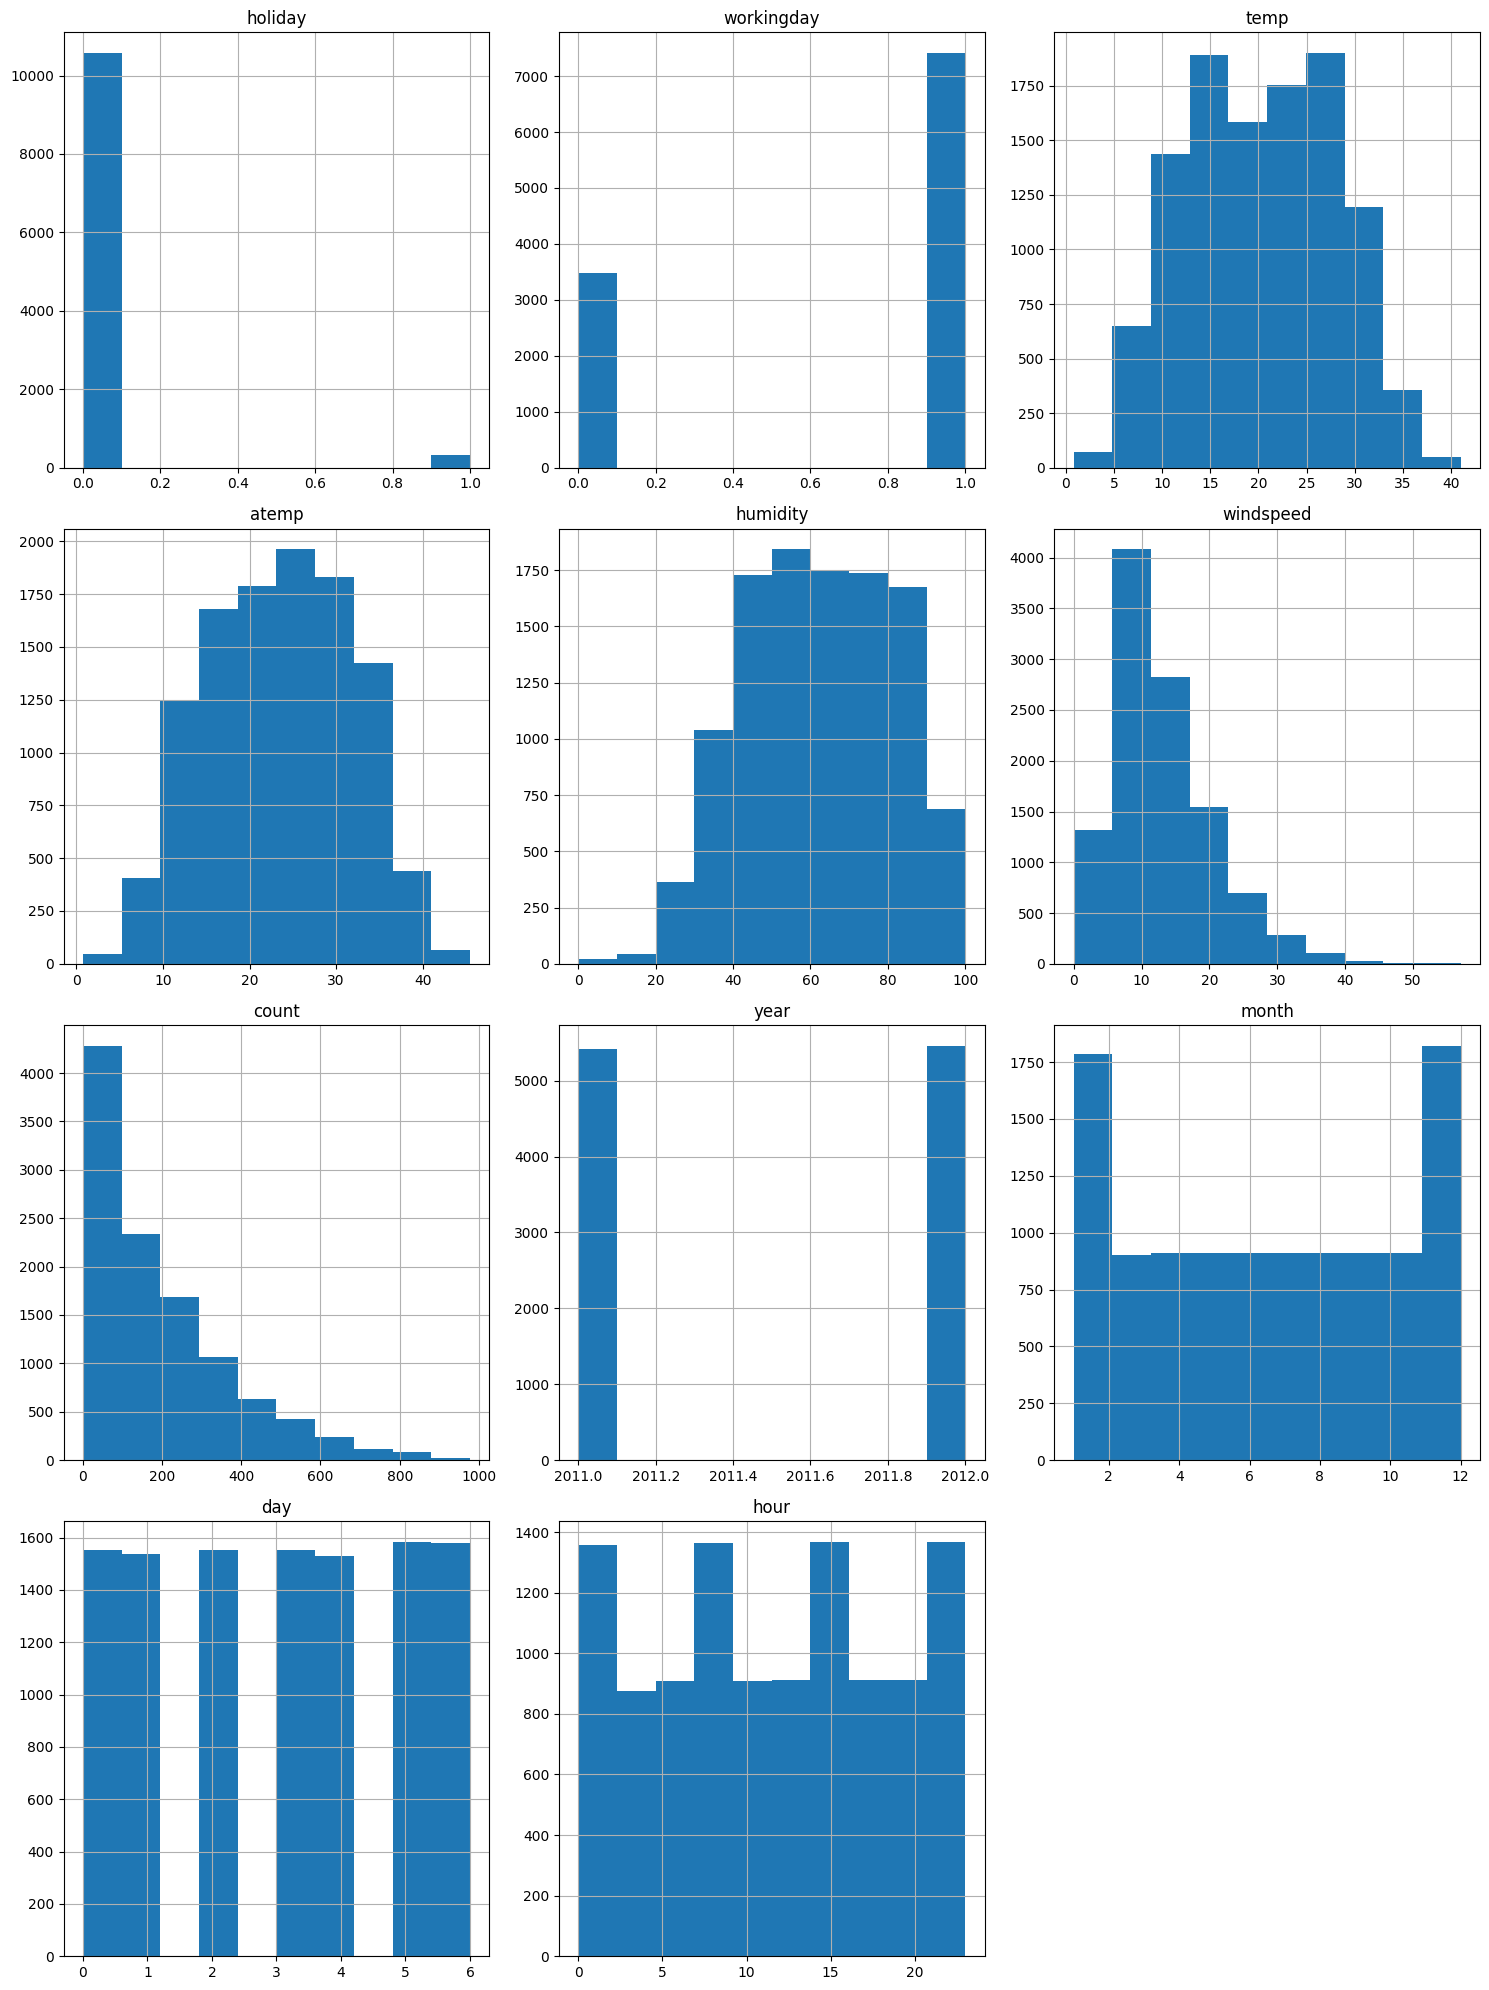

In [42]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))  
plt.tight_layout()
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [15]:
predictor_new_features = TabularPredictor(label='count',eval_metric='root_mean_squared_error').fit( train_data=train,
                                                                                                  
    time_limit=600,
    presets="best_quality",)

No path specified. Models will be saved in: "AutogluonModels/ag-20240422_144723"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240422_144723/ds_sub_fit/sub_fit_ho.
/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDepen

[1000]	valid_set's rmse: 40.4884
[2000]	valid_set's rmse: 39.2267
[3000]	valid_set's rmse: 38.8995
[4000]	valid_set's rmse: 38.816
[5000]	valid_set's rmse: 38.8681
[1000]	valid_set's rmse: 37.0371
[2000]	valid_set's rmse: 36.088
[3000]	valid_set's rmse: 36.0387
[1000]	valid_set's rmse: 41.016
[2000]	valid_set's rmse: 39.6634
[3000]	valid_set's rmse: 39.278
[4000]	valid_set's rmse: 39.1082
[5000]	valid_set's rmse: 39.0568
[6000]	valid_set's rmse: 39.0244
[7000]	valid_set's rmse: 39.1083
[8000]	valid_set's rmse: 39.1444
[1000]	valid_set's rmse: 39.9548
[2000]	valid_set's rmse: 37.8431
[3000]	valid_set's rmse: 37.2082
[4000]	valid_set's rmse: 36.9424
[5000]	valid_set's rmse: 36.7961
[6000]	valid_set's rmse: 36.6911
[7000]	valid_set's rmse: 36.6776
[8000]	valid_set's rmse: 36.6415
[9000]	valid_set's rmse: 36.6363
[10000]	valid_set's rmse: 36.6178
[1000]	valid_set's rmse: 36.4508
[2000]	valid_set's rmse: 35.6124
[3000]	valid_set's rmse: 35.5452
[1000]	valid_set's rmse: 38.994
[2000]	valid_s

	-36.9384	 = Validation score   (-root_mean_squared_error)
	60.94s	 = Training   runtime
	1.63s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 33.21s of the 83.17s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 37.34
[1000]	valid_set's rmse: 37.278
[1000]	valid_set's rmse: 38.638
[2000]	valid_set's rmse: 38.2473
[1000]	valid_set's rmse: 37.4715
[2000]	valid_set's rmse: 36.9546
[3000]	valid_set's rmse: 36.9086
[1000]	valid_set's rmse: 34.8153
[1000]	valid_set's rmse: 37.7162
[2000]	valid_set's rmse: 37.2622
[1000]	valid_set's rmse: 34.867
[1000]	valid_set's rmse: 37.0459


	-36.6664	 = Validation score   (-root_mean_squared_error)
	17.58s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 14.12s of the 64.09s of remaining time.
	-40.569	 = Validation score   (-root_mean_squared_error)
	4.83s	 = Training   runtime
	0.59s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 8.31s of the 58.28s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 63.
	Ran out of time, early stopping on iteration 161.
	Ran out of time, early stopping on iteration 170.
	Ran out of time, early stopping on iteration 171.
	Ran out of time, early stopping on iteration 179.
	Ran out of time, early stopping on iteration 190.
	Ran out of time, early stopping on iteration 212.
	Ran out of time, early stopping on iteration 252.
	-51.3794	 = Validation score   (-root_mean_squared_error)
	7.94s

[1000]	valid_set's rmse: 37.3955
[2000]	valid_set's rmse: 35.8564
[3000]	valid_set's rmse: 35.7733
[4000]	valid_set's rmse: 35.749
[1000]	valid_set's rmse: 38.4092
[2000]	valid_set's rmse: 36.984
[3000]	valid_set's rmse: 36.7048
[4000]	valid_set's rmse: 36.6577
[5000]	valid_set's rmse: 36.6682
[6000]	valid_set's rmse: 36.6427
[1000]	valid_set's rmse: 36.9097
[2000]	valid_set's rmse: 35.5912
[3000]	valid_set's rmse: 35.1505
[4000]	valid_set's rmse: 34.9993
[5000]	valid_set's rmse: 34.869
[6000]	valid_set's rmse: 34.8566
[7000]	valid_set's rmse: 34.8204
[8000]	valid_set's rmse: 34.7883
[9000]	valid_set's rmse: 34.7902
[10000]	valid_set's rmse: 34.8132
[1000]	valid_set's rmse: 38.5003
[2000]	valid_set's rmse: 37.0041
[3000]	valid_set's rmse: 36.7718
[4000]	valid_set's rmse: 36.7333
[5000]	valid_set's rmse: 36.7654
[1000]	valid_set's rmse: 40.4421
[2000]	valid_set's rmse: 38.8755
[3000]	valid_set's rmse: 38.3805
[4000]	valid_set's rmse: 38.1652
[5000]	valid_set's rmse: 38.0954
[6000]	valid

	-36.4599	 = Validation score   (-root_mean_squared_error)
	66.93s	 = Training   runtime
	2.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 223.5s of the 371.85s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 35.0742
[1000]	valid_set's rmse: 34.1338
[2000]	valid_set's rmse: 33.9294
[1000]	valid_set's rmse: 34.257
[2000]	valid_set's rmse: 33.6373
[3000]	valid_set's rmse: 33.4395
[4000]	valid_set's rmse: 33.4325
[1000]	valid_set's rmse: 37.3575
[2000]	valid_set's rmse: 37.1945
[1000]	valid_set's rmse: 38.1734
[2000]	valid_set's rmse: 37.9207
[1000]	valid_set's rmse: 33.4459
[2000]	valid_set's rmse: 33.2585
[1000]	valid_set's rmse: 39.4999
[1000]	valid_set's rmse: 36.2444


	-35.7969	 = Validation score   (-root_mean_squared_error)
	20.23s	 = Training   runtime
	0.56s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 201.56s of the 349.91s of remaining time.
	-39.5874	 = Validation score   (-root_mean_squared_error)
	5.32s	 = Training   runtime
	0.59s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 195.1s of the 343.45s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 2535.
	Ran out of time, early stopping on iteration 2631.
	Ran out of time, early stopping on iteration 2642.
	Ran out of time, early stopping on iteration 2766.
	Ran out of time, early stopping on iteration 2849.
	Ran out of time, early stopping on iteration 2980.
	Ran out of time, early stopping on iteration 3182.
	Ran out of time, early stopping on iteration 3649.
	-35.8035	 = Validation score   (-root_mean_squared

In [16]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -33.828199  root_mean_squared_error       4.694379  318.096013                0.000640           0.040877            3       True         15
1      WeightedEnsemble_L2  -34.152607  root_mean_squared_error       3.874574  282.375578                0.000628           0.026046            2       True          8
2          CatBoost_BAG_L2  -34.190445  root_mean_squared_error       4.063075  313.437418                0.045903          31.040123            2       True         12
3     ExtraTreesMSE_BAG_L2  -34.263571  root_mean_squared_error       4.647835  287.015013                0.630664           4.617718            2       True         13
4   NeuralNetFastAI_BAG_L2  -34.579707  root_mean_squared_error       4.294481  354.269540   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -116.01336808709685,
  'KNeighborsDist_BAG_L1': -112.43323719360711,
  'LightGBMXT_BAG_L1': -36.45988391821316,
  'LightGBM_BAG_L1': -

In [17]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


0    13.855337
1     5.912525
2     3.797677
3     3.084743
4     2.875097
Name: count, dtype: float32

In [20]:
negative_values = predictions_new_features.value_counts().get(-1, 0)  # Count occurrences of -1 (negative values)
print(f"Number of negative values: {negative_values}")

Number of negative values: 0


In [22]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features<0] = 0    # (In case, if negative values exist in the predictions, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_features.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [23]:
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_features.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

In [25]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [26]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 226kB/s]
Successfully submitted to Bike Sharing Demand

In [27]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-22 15:03:54  new features                       complete  0.46349      0.46349       
submission_new_hpo.csv       2024-04-22 09:43:21  new features with hyperparameters  complete  1.37429      1.37429       
submission_new_features.csv  2024-04-22 05:26:27  new features                       complete  1.80593      1.80593       
submission.csv               2024-04-22 05:13:17  first raw submission               complete  1.80593      1.80593       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [15]:
from ray import tune  

hyperparameters = {
    'model': 'RandomForestClassifier',
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
}
predictor_new_hpo = TabularPredictor(label='count',eval_metric='root_mean_squared_error').fit(
    train_data=train,
    presets="good_quality",
    
    hyperparameter_tune_kwargs=hyperparameters,
    time_limit=600,
)
                                                                                                                                                                               
   
    

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
2024-04-22 20:12:02,389	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-22 20:12:02,588	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
No path specified. Models will be saved in: "AutogluonModels/ag-20240422_201202"
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatl

In [16]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3 -129.455403  root_mean_squared_error       0.229506  28.590886                0.000620           0.013252            3      False          4
1       LightGBMLarge_BAG_L1 -130.132290  root_mean_squared_error       0.191169  18.661050                0.191169          18.661050            1      False          1
2        WeightedEnsemble_L2 -130.132290  root_mean_squared_error       0.191742  18.664528                0.000573           0.003478            2      False          2
3       LightGBMLarge_BAG_L2 -131.189073  root_mean_squared_error       0.228887  28.577635                0.037718           9.916585            2      False          3
4   WeightedEnsemble_L3_FULL         NaN  root_mean_squared_error            NaN   2.075

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMLarge_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2_FULL': 'WeightedEnsembleModel',
  'LightGBMLarge_BAG_L2_FULL': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3_FULL': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMLarge_BAG_L1': -130.13228993716103,
  'WeightedEnsemble_L2': -130.13228993716103,
  'LightGBMLarge_BAG_L2': -131.18907271955018,
  'WeightedEnsemble_L3': -129.4554034789057,
  'LightGBMLarge_BAG_L1_FULL': None,
  'WeightedEnsemble_L2_FULL': None,
  'LightGBMLarge_BAG_L2_FULL': None,
  'WeightedEnsemble_L3_FULL': None},
 'model_best': 'WeightedEnsemble_L3_FULL',
 'model_paths': {'LightGBMLarge_BAG_L1': ['LightGBMLarge_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'LightGBMLarge_BAG_L2': ['LightGB

In [17]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    80.404945
1    89.741196
2    89.741196
3    82.191628
4    82.191628
Name: count, dtype: float32

In [18]:
# Remember to set all negative values to zero
 
predictions_new_hpo[predictions_new_hpo<0] = 0    # (In case, if negative values exist in the predictions_new_features, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_hpo.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [19]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

In [20]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 298kB/s]
Successfully submitted to Bike Sharing Demand

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-22 20:13:50  new features with hyperparameters  complete  1.34322      1.34322       
submission_new_hpo.csv       2024-04-22 15:07:28  new features with hyperparameters  complete  0.51921      0.51921       
submission_new_features.csv  2024-04-22 15:03:54  new features                       complete  0.46349      0.46349       
submission_new_hpo.csv       2024-04-22 09:43:21  new features with hyperparameters  complete  1.37429      1.37429       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

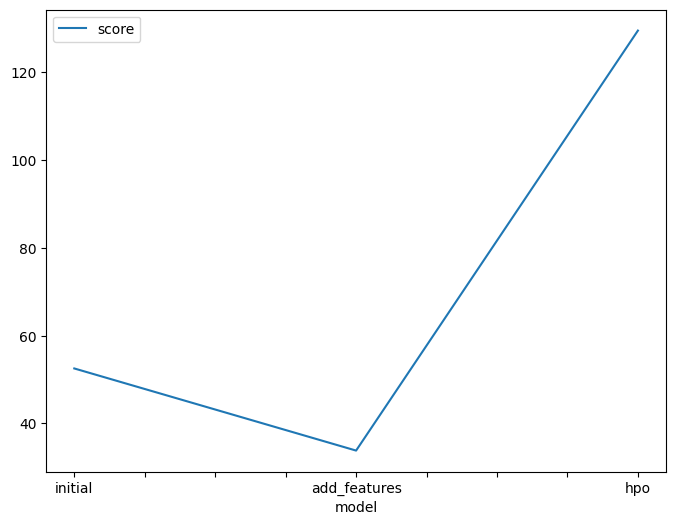

In [23]:

# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
df = pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "score": [52.528, 33.828, 129.455],
})

# Now you can plot the DataFrame
fig = df.plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')


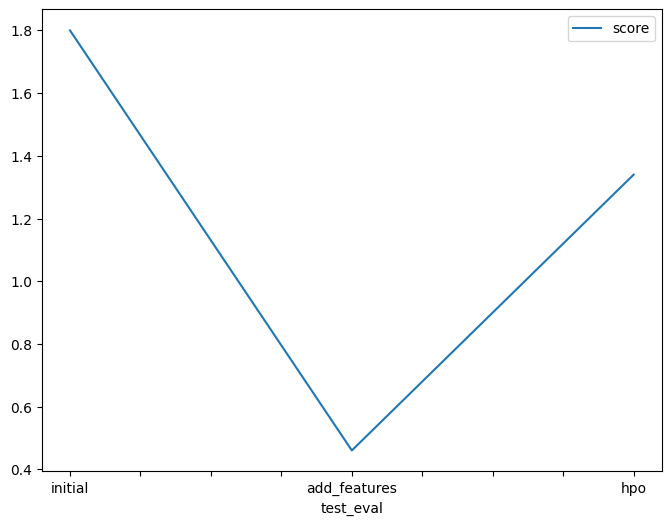

In [24]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80, 0.46, 1.34]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [25]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["prescribed_values", "prescribed_values", "Tree-Based Models: (GBM, XT, XGB & RF)"],
    "hpo2": ["prescribed_values", "prescribed_values","hyperparameters" ],
    "hpo3": ["presets: best quality", "presets: best quality", "presets: good quality"],
    "score": [1.80, 0.46, 1.34]
})


model                                    hpo1               hpo2  \
0       initial                       prescribed_values  prescribed_values   
1  add_features                       prescribed_values  prescribed_values   
2           hpo  Tree-Based Models: (GBM, XT, XGB & RF)    hyperparameters   

                    hpo3  score  
0  presets: best quality   1.80  
1  presets: best quality   0.46  
2  presets: good quality   1.34